<a href="https://colab.research.google.com/github/Amir-Shakiba/Image-generation/blob/VAE-mnist/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow as tf 

In [ ]:
(x_train,_),(x_test,_) = keras.datasets.mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

11490434/11490434 [==============================] - 3s 0us/step


In [ ]:
latent_dim = 2

In [ ]:
class Sampler(layers.Layer):
  def call(self,inputs):
    mu,log_var = inputs
    shape = tf.shape(mu)
    epsilon = tf.random.normal(shape=shape)
    return mu+tf.exp(0.5*log_var)*epsilon

In [ ]:
encoder_input = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32,3,activation = 'relu',strides=2, padding = 'same')(encoder_input)
x = layers.Conv2D(64,3,activation = 'relu',strides=2, padding = 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16)(x)
mu = layers.Dense(latent_dim)(x)
log_var = layers.Dense(latent_dim)(x)
z = Sampler()([mu,log_var])
encoder = Model(encoder_input,[mu,log_var,z])
encoder.summary()

In [ ]:
decoder_input = keras.Input(shape=(latent_dim,))
y = layers.Dense(7*7*64)(decoder_input)
y = layers.Reshape((7,7,64))(y)
y = layers.Conv2DTranspose(64,3,activation = 'relu',strides =2,padding = 'same')(y)
y = layers.Conv2DTranspose(32,3,activation = 'relu',strides =2,padding = 'same')(y)
decoder_output = layers.Conv2DTranspose(1,3,activation = 'sigmoid',strides =1,padding = 'same')(y)
decoder = Model(decoder_input,decoder_output)
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        289 

In [ ]:
class VAE(Model):
  def __init__(self,encoder,decoder):
    super(VAE,self).__init__()
    self.encoder =encoder
    self.decoder = decoder
    self.mu = None
    self.log_var = None

  def call(self,inputs):
    self.mu,self.log_var,z = encoder(inputs)
    outputs = decoder(z)
    return outputs  

In [ ]:
def vae_loss(y_true,y_pred):
  bce_loss = keras.losses.binary_crossentropy(y_true,y_pred)
  kl_loss = -0.5*tf.reduce_mean(1+vae.log_var-tf.square(vae.mu)-tf.exp(vae.log_var))
  kl_weight = 0.01
  return kl_weight*kl_loss+bce_loss

In [ ]:
vae = VAE(encoder,decoder)

In [ ]:
vae.compile(loss=vae_loss,optimizer = 'adam')


In [ ]:
vae.fit(x = x_train, y= x_train,epochs =10)

Epoch 1/10
1875/1875 [==============================] - 17s 4ms/step - loss: 0.2401
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2239
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2208
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2192
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2181
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2173
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2168
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2161
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2157
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2153


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


1/1 [==============================] - 0s 13ms/step


1875/1875 [==============================] - 3s 2ms/step


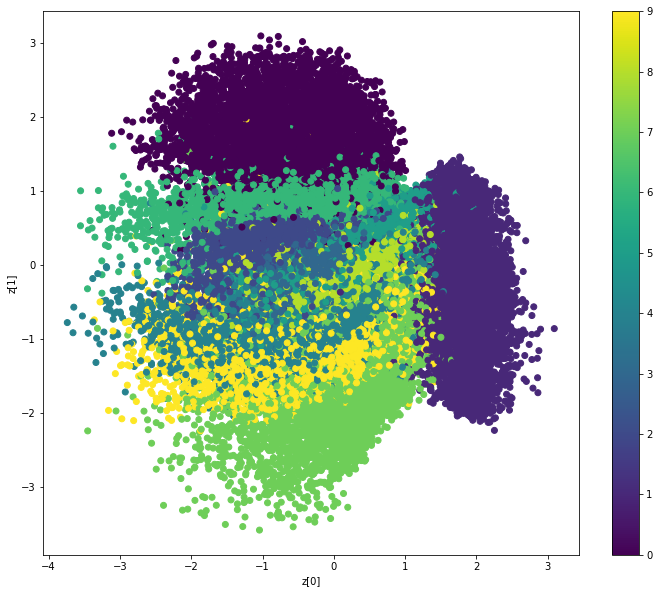

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)
